<a href="https://colab.research.google.com/github/r0c10/DataScience/blob/master/Tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tarea 2 - Regresion Polinomial & Feature engineering
### Parte 1 - Modelo exponencial de covid-19 usando feature-eng
Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
Aplicar regresión lineal sobre la variable "Confirmed" transformada.
Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [6]:
from google.colab import files
uploaded = files.upload()
import io

covid_df = pd.read_csv(io.StringIO(uploaded['covid_19_clean_complete.csv'].decode('utf-8')))
covid_df["Date"] = pd.to_datetime(covid_df["Date"],infer_datetime_format = True)
covid_gt = covid_df[(covid_df["Country/Region"] == 'Guatemala') & (covid_df["Confirmed"] > 0)].copy()
covid_gt.head()

Saving covid_19_clean_complete.csv to covid_19_clean_complete (1).csv


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
13851,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0
14115,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0
14379,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0
14643,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0
14907,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0


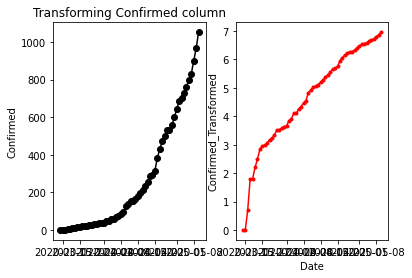

In [7]:
# Transformando la variable Confirmed

x = covid_gt["Date"]

y1 = covid_gt["Confirmed"]
covid_gt["Confirmed_Transformed"] = np.log(covid_gt["Confirmed"])
y2 = covid_gt["Confirmed_Transformed"]


plt.subplot(1, 2, 1)
plt.plot(x, y1, 'ko-')
plt.title('Transforming Confirmed column')
plt.ylabel('Confirmed')


plt.subplot(1, 2, 2)
plt.plot(x, y2, 'r.-')
plt.xlabel('Date')
plt.ylabel('Confirmed_Transformed')

plt.show()

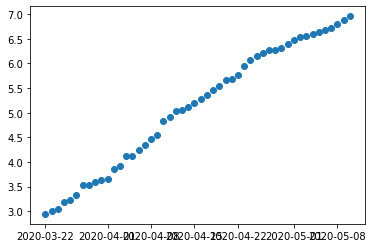

In [8]:
# Modelo lineal(datos desde el dia 22)
cv_gt_after22 = covid_gt[covid_gt.Date >= '2020-03-22'].copy()
plt.scatter(cv_gt_after22["Date"],cv_gt_after22["Confirmed_Transformed"])

In [0]:
# Fecha a número de día
date_number = cv_gt_after22["Date"].iloc[0]
cv_gt_after22["Days_Number"] = (cv_gt_after22["Date"] - date_number).dt.days

In [0]:
#definiendo variables X y Y
numbers_array = np.array(cv_gt_after22["Days_Number"])
y_ = np.array(cv_gt_after22["Confirmed_Transformed"])
to_ones = np.ones_like(numbers_array)
x_ = np.transpose(np.stack((np.float32(numbers_array),np.float32(to_ones))))

In [0]:
## Mean Squared Error Cost Function
def error(y,y_pred):
  with graph_tf.as_default() as g:
    with tf.name_scope("error"):
      error = 1/2*tf.reduce_mean(tf.math.square(y - y_pred),name="error")
      return error

# Function
def run_training(tens_x,tens_y,epochs,lr,parameteres):
  with graph_tf.as_default() as g:
    with tf.name_scope('Predictions') as scope:
      y_pred = tf.transpose(tf.matmul(tens_x,parameteres),name="Predictions")
    with tf.name_scope('Gradient') as scope:
      gradient = tf.gradients(error(tens_y,y_pred),parameteres,name="Gradient")
      update = tf.assign(parameteres, parameteres - gradient[0] * lr,name="update_params")
    err = error(tens_y,y_pred)
    scalar = tf.summary.scalar('Error_Graph', err)
    with tf.train.MonitoredSession() as session:
        feed_dict = {tens_x:x_, tens_y:y_}
        writer = tf.summary.FileWriter('./logs/'+datetime.datetime.now().strftime("%Y%m%d-%H")+'lr_'+str(lr)+'epochs_'+str(epochs), session.graph)
        for i in range(epochs):
            session.run(update,feed_dict=feed_dict)
            summary = session.run(scalar,feed_dict)
            writer.add_summary(summary, (i+1))
        return session.run(parameteres),session.run(err,feed_dict)


In [12]:
graph_tf = tf.Graph()
with graph_tf.as_default() as g:
  tensor_x = tf.placeholder(tf.float32, shape=None, name="X")
  tensor_y = tf.placeholder(tf.float32,[len(x_)],"Y")

  Parameteres = tf.get_variable(name="parameteres",dtype=tf.float32,shape=[2,1],
                      initializer=tf.truncated_normal_initializer(stddev = 0.01))

param,error_ = run_training(tensor_x,tensor_y,50000,0.001,Parameteres)
print("pendiente: ",param[0])
print("intercepto: ",param[1])
print("error: ",error_)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
pendiente:  [0.0864872]
intercepto:  [2.9938657]
error:  0.010278707


In [28]:
def Pred_covid(fecha):
    number_day = (pd.to_datetime(fecha) - date_number).days
    pred = np.exp(param[1][0] + number_day*param[0][0])
    return pred

# Cantidad de casos para el 30 de mayo
date = '2020-05-30'
confirmed =  int(Pred_covid('2020-05-30'))
print('para la fecha',date,'habrán aproximadamente',confirmed,'casos confirmados')

para la fecha 2020-05-30 habrán aproximadamente 7796 casos confirmados


In [20]:
from google.colab import files
uploaded = files.upload()


Saving Main_Graph.png to Main_Graph (2).png


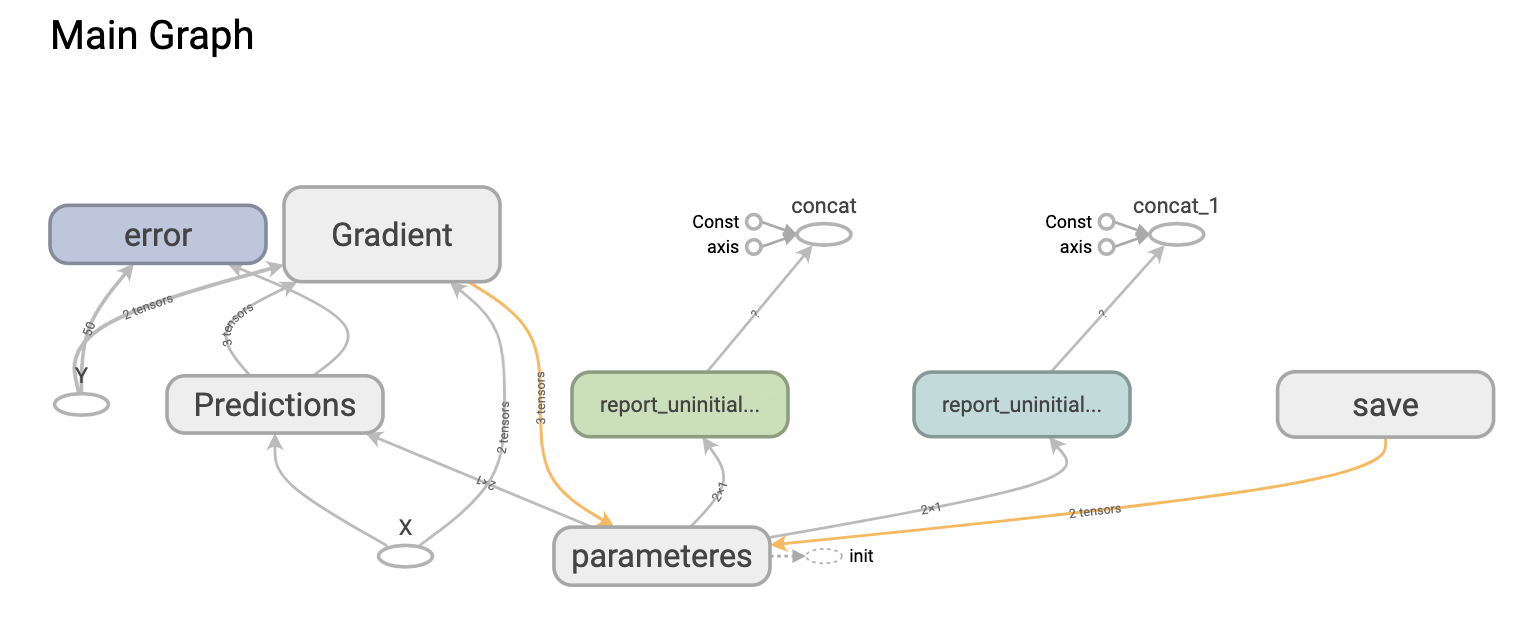

In [22]:
from IPython.display import Image
Image("Main_Graph.png")

In [24]:
from google.colab import files
uploaded = files.upload()

Saving Error_Graph.png to Error_Graph.png


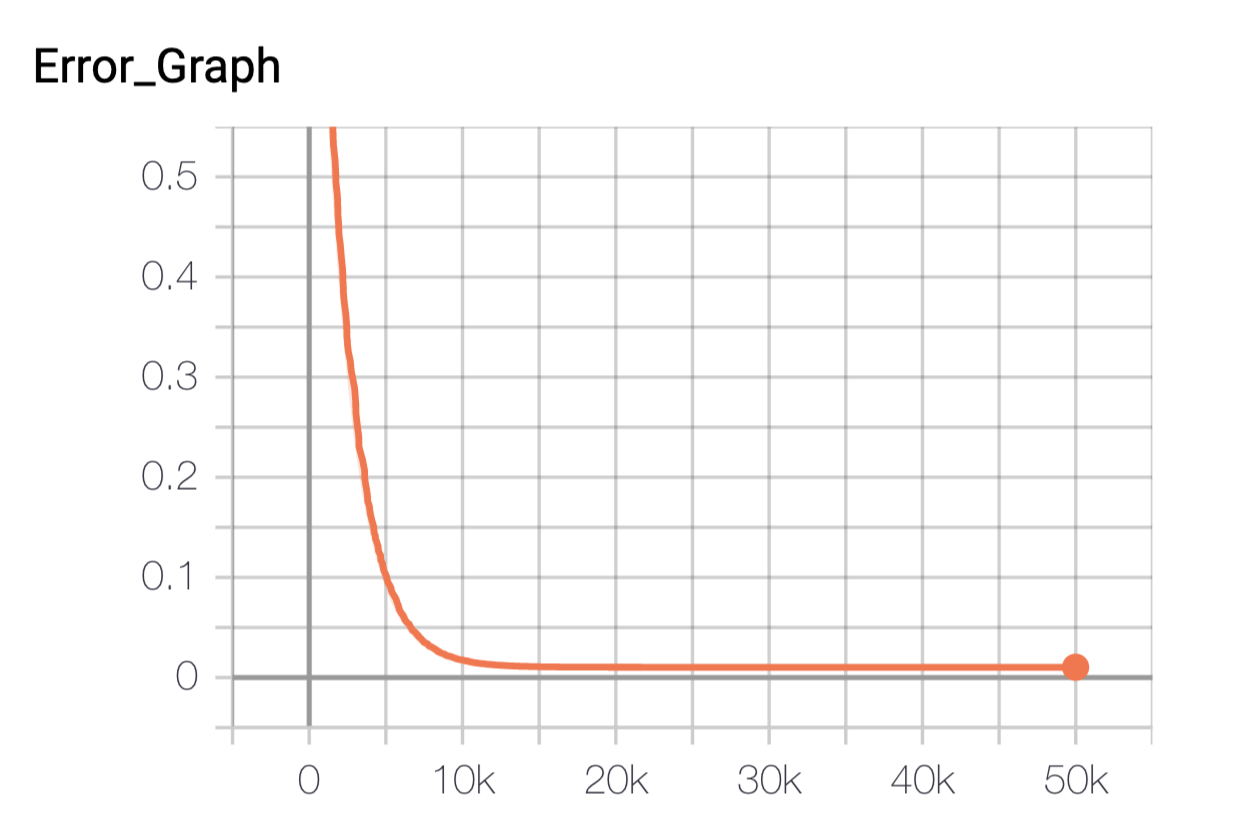

In [25]:
from IPython.display import Image
Image("Error_Graph.png")

### Parte 2 - Modelo polinomial de calidad de vinos
Es permitido utilizar sklearn.preprocessing.polynomialfeatures
Instrucciones
Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ): graficando y viendo la forma en que se comportan los datos.

Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :

[𝑎,𝑏,𝑎2,𝑏2,𝑎𝑏] 

No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:

[1,𝑎,𝑏,𝑎2,𝑏2,𝑎𝑏] 

Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:

Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando names , y name_scope como visto en clase).

Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2 crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [0]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [29]:
from google.colab import files
uploaded = files.upload()
import io

Saving winequality-red.csv to winequality-red.csv


In [30]:
wine_q= pd.read_csv('winequality-red.csv')
wine_q.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### EDA

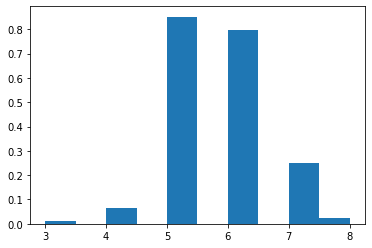

In [31]:
#Quality (variable a predecir)
plt.hist(wine_q["quality"],density=True)
plt.show()

Variable dependiente vs independientes

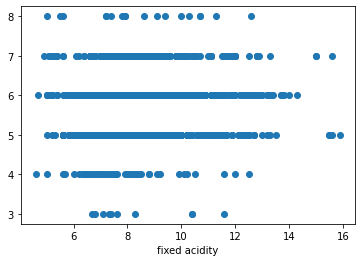

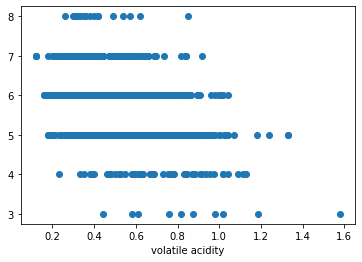

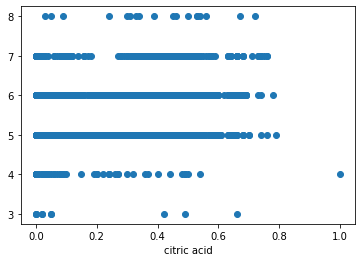

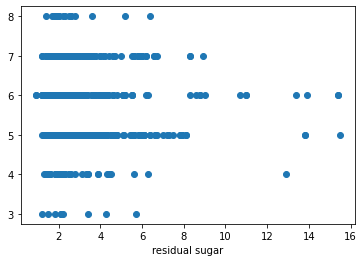

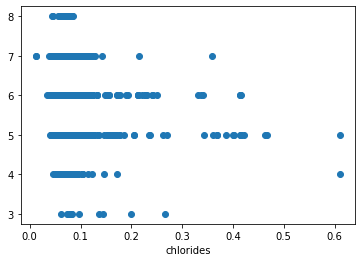

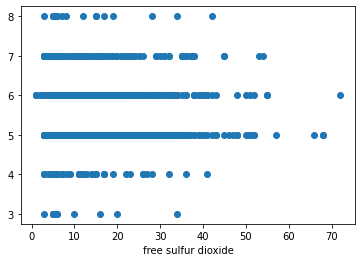

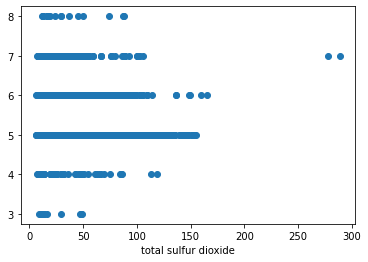

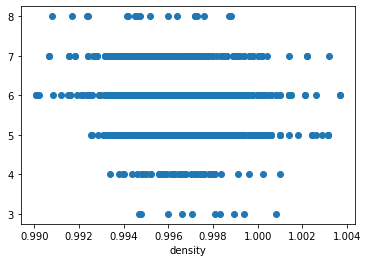

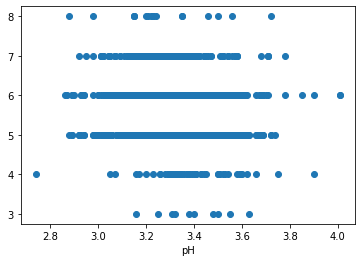

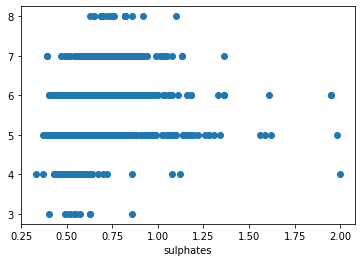

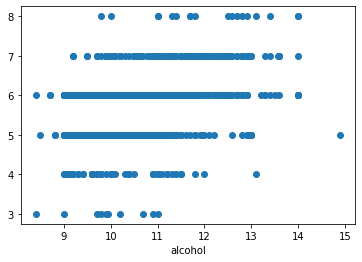

In [40]:
for col in wine_q.columns[0:11]:
    plt.scatter(wine_q[col], wine_q["quality"])
    plt.xlabel(col)
    plt.show()

#### Correlación

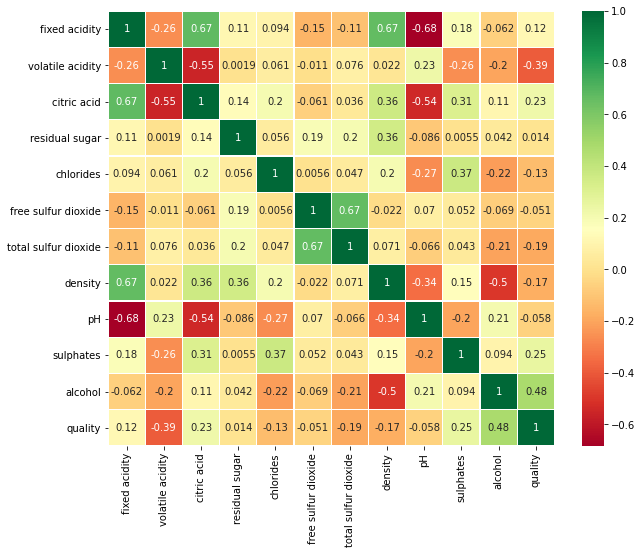

In [36]:
import seaborn as sns
sns.heatmap(wine_q.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Del análisis previo se puede concluir que:
* La variable alcohol tiene una relación positiva moderada (0.48) con la variable respuesta.
* La variable volatile acidity presenta una relación negativa débil (-0.39) con la variable respuesta.
* Se considerará la regresión lineal múltiple para la predicción.

In [0]:
# Buscando la mejor combinación entre todas las variables predictoras en una muestra aleatoria
import itertools
fea = wine_q.columns.values[0:11] #caracteristicas

corrs_d = []
for f in range(1, len(fea)+1):
    for s in itertools.combinations(fea, f):
        lm = LinearRegression()
        c = list(s)
        x = wine_q[c]
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,wine_q["quality"],test_size=0.2)
        lm = LinearRegression()
        lm.fit(Xtrain,Ytrain)
        corrs_d.append([c,lm.score(Xtrain,Ytrain)])

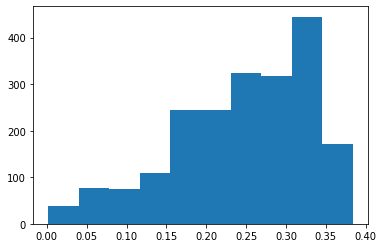

In [46]:
corr_wine = pd.DataFrame(corrs_d, columns=["X","corr"])
plt.hist(corr_wine["corr"])
plt.show()

En el gráfico anterior se aprecia que la correlación despues de seleccionar de 4 a 5 variables,se concentra de 0.25 a 0.35, analizando X aleatoriamente, se encontro la mejor combinación de variables en terminos de cantidad y la variación del error. Si se seleccionan todas o más de 6 variables la disminución del error es mínima.

X = ['volatile acidity', 'pH', 'sulphates','density', 'alcohol']

El problema se resolvera con regresión polinomial, probando diferentes grados, con las variables seleccionadas

In [57]:
# Creando función para transformar polinomio
def transoform_data(X,grad):
  poly = PolynomialFeatures(grad)
  return np.float32(poly.fit_transform(X))

# Eligiendo solo las variables seleccionadas anteriormente
feature_cols = ['volatile acidity', 'pH', 'sulphates','density', 'alcohol']
X = wine_q[feature_cols]
Y = wine_q["quality"]

# Particionando la data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2)

## Mean Squared Error Cost Function
def error(y,y_pred):
  with graph_tf.as_default() as g:
    with tf.name_scope("error"):
      error = 1/2*tf.reduce_mean(tf.math.square(y - y_pred),name="error")
      return error

def training(X,Y,epochs,lr,w,p):
  with g2.as_default() as g:
    with tf.name_scope('Predictions') as scope:
      y_hat = tf.transpose(tf.matmul(X,w),name="PredictionS") #obteniendo predicciones
    with tf.name_scope('Gradient') as scope:
      gradiente = tf.gradients(error(Y,y_hat),w,name="Gradient")
      update = tf.assign(w, w - gradiente[0] * lr,name="update_params")
    err = error(Y,y_hat)
    scalar = tf.summary.scalar('Error_Graph', err)
    with tf.train.MonitoredSession() as session:
        feed_dict = {X:XT, Y:Ytrain}
        writer = tf.summary.FileWriter('./logs2/'+datetime.datetime.now().strftime("%Y%m%d-%H")+'pol_grad_'+str(p), session.graph)
        for i in range(epochs):
            session.run(update,feed_dict=feed_dict)
            summary = session.run(scalar,feed_dict)
            writer.add_summary(summary, (i+1))
        return session.run(w),session.run(err,feed_dict)


list_w = []
for i in [2,3,5]:
    g2 = tf.Graph()
    XT = transoform_data(Xtrain,i)

    with g2.as_default() as g:
        tensor_x = tf.placeholder(tf.float32, shape=None, name="X")
        tensor_y = tf.placeholder(tf.float32,[len(XT)],"Y")

        W = tf.get_variable(name="w",dtype=tf.float32,shape=[XT.shape[1],1],
                      initializer=tf.truncated_normal_initializer(stddev = 0.01))

    w,e = training(tensor_x,tensor_y,80000,0.000001,W,i)
    list_w.append([i,w,e])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Saving Error_Graph_2.png to Error_Graph_2.png


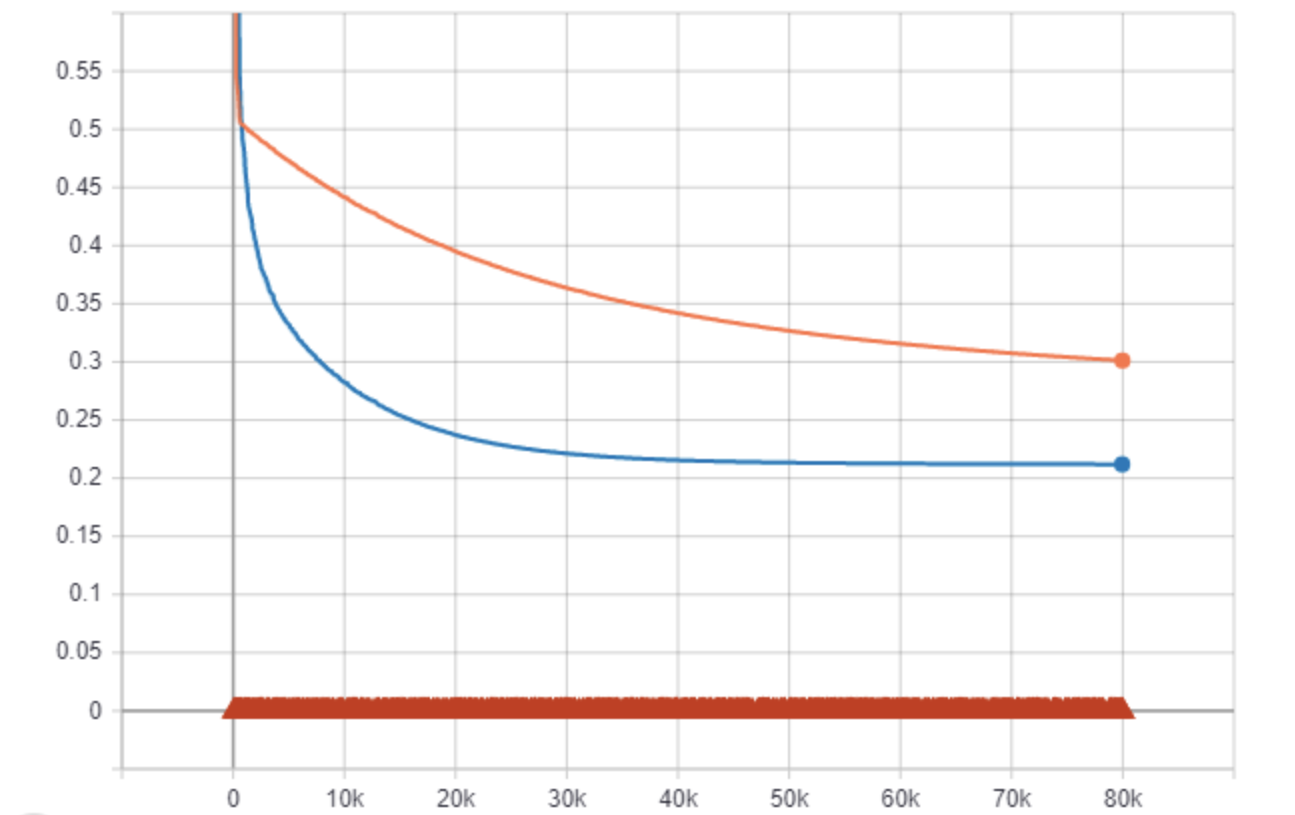

In [75]:
# El grafo es igual que el de la parte 1
from google.colab import files
uploaded = files.upload()
from IPython.display import Image
Image("Error_Graph_2.png")

Se aprecia en la gráfica del error, que el polinomio de grado 3, el error converge a su punto mínimo, el error con el polinomio de grado 5, resulto con valores indefinidos.

Por lo que se pasa a analizar las predicciones y el error medio de los polinomios de grado 2 y 3:

0    0.320370
1    0.219293
2         NaN
Name: error, dtype: float64

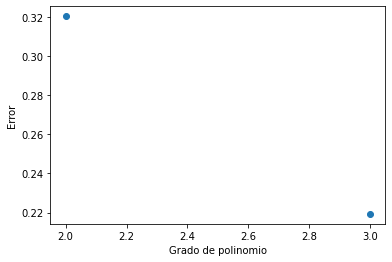

In [59]:
data_w = pd.DataFrame(list_w, columns=['grado','parametros','error'])
pol = np.array([2,3,5])
plt.scatter(pol,data_w["error"])
plt.xlabel("Grado de polinomio")
plt.ylabel("Error")
data_w["error"]

La gráfica muestra que en el polinomio de grado 3, el error es minímo.

Obteniendo el porcentaje de error, con el error cuadrático y predicciones, para los datos de prueba.

In [0]:
def predict(params,grad):
    x_test = transoform_data(Xtest,grad)
    pred = np.matmul(x_test,params)
    return np.rint(pred)

In [62]:
predicciones = pd.DataFrame(Ytest)
for i in list_w:
    pred = predict(i[1],i[0])  
    predicciones["pred_quality_"+str(i[0])] = pred
predicciones.head()

,quality,pred_quality_2,pred_quality_3,pred_quality_5
327,5,6.0,6.0,NaN
1046,6,6.0,5.0,NaN
1501,5,5.0,5.0,NaN
111,5,5.0,5.0,NaN
1258,6,6.0,6.0,NaN


In [0]:
#obtener porcentaje de eror
def error_porcentaje(y_real,y_pred,feature_cols):
    SSD = sum((y_real-y_pred)**2)
    RSE = np.sqrt(SSD/(len(Xtest)-len(feature_cols)-1))
    quality_mean = np.mean(y_real)
    error = RSE/quality_mean
    return error

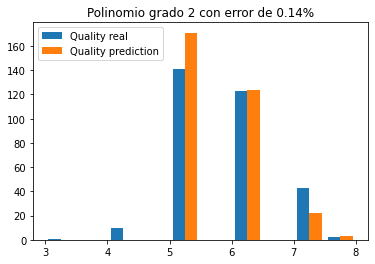

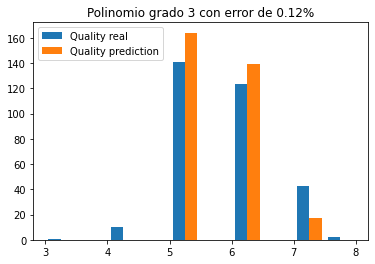

In [74]:
# Datos reales vs predicciones
error_2 = error_porcentaje(predicciones["quality"],predicciones["pred_quality_2"],feature_cols)
error_3 = error_porcentaje(predicciones["quality"],predicciones["pred_quality_3"],feature_cols)

plt.hist([predicciones["quality"], predicciones["pred_quality_2"]], label=['Quality real', 'Quality prediction'])
plt.legend(loc='upper left')
plt.title("Polinomio grado 2 con error de "+str(round(error_2, 2))+"%")
plt.show()

plt.hist([predicciones["quality"], predicciones["pred_quality_3"]], label=['Quality real', 'Quality prediction'])
plt.legend(loc='upper left')
plt.title("Polinomio grado 3 con error de "+str(round(error_3, 2))+"%")
plt.show()

CONCLUSIÓN. En la gráfica se observa que el modelo que mejor se ajusta a los datos, (y que tiene menor error) es el del polinimio de grado 3, tomando diferentes muestras aleatorias.

Los datos se concentran tanto en las predicciones como en los datos reales entre 5 y 6 respectivamente.